In [1]:
import pandas as pd
import numpy as np
from src.Particle import ParticleType
from src.JetBuilder import JetBuilder
from numpy import vectorize
from src.JetImage import JetImage, JetImageCalculator, JetImageCalculatorPandas, JetImageAvarageCalculator
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split

In [2]:
data_gluon = pd.read_csv('Dados/g_jets.csv', header=None, sep=' ')
data_quark = pd.read_csv('Dados/q_jets.csv', header=None, sep=' ')
data_top = pd.read_csv('Dados/t_jets.csv', header=None, sep=' ')

In [3]:
#criando os jatos
jet_builder = JetBuilder()

gluon_jets = jet_builder.create_jets(data_frame=data_gluon[:1000], jet_type=ParticleType.Gluon)
quark_jets = jet_builder.create_jets(data_frame=data_quark[:1000], jet_type=ParticleType.LightQuark)
top_jets = jet_builder.create_jets(data_frame=data_top[:1000], jet_type=ParticleType.Top)

In [4]:
pix1 = 9
pix2 = 9
area = pix1*pix2
jet_image = JetImage((-0.3, 0.3), (-0.3, 0.3), pix1, pix2, JetImageCalculator())

In [5]:
first_gluon_image = jet_image.create_jet_image(gluon_jets[50])

Text(0, 0.5, '$\\eta^{rel}$')

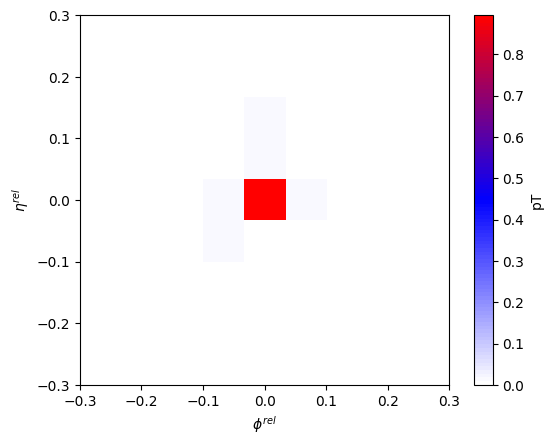

In [6]:
# Create a custom colormap that transitions from white to blue to red
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]  # White, Blue, Red
n_bins = 100  # Number of bins for interpolation
custom_cmap = LinearSegmentedColormap.from_list('white_blue_red', colors, N=n_bins)
plt.imshow(first_gluon_image, cmap=custom_cmap, extent=(-0.3, 0.3, -0.3, 0.3))
plt.colorbar(label='pT')
plt.xlabel(r'$\phi^{rel}$')
plt.ylabel(r'$\eta^{rel}$')

In [ ]:
#Cria um array pra cada jato e associa a ele se ele é um g, t ou q
t_tam = len(top_jets)
q_tam = len(quark_jets)
g_tam = len(gluon_jets)
tam_particulas = t_tam + q_tam + g_tam

dados_particulas = np.empty((tam_particulas,area))
label = np.zeros((t_tam+q_tam+g_tam,3))

for i in range(t_tam):

    top_image = jet_image.create_jet_image(top_jets[i])
    top_image = top_image.reshape(1,area)

    label[i,0] = 1.0
    dados_particulas[i] = top_image

for i in range(q_tam):

    quark_image = jet_image.create_jet_image(quark_jets[i])
    quark_image = quark_image.reshape(1,area)

    label[i+t_tam,1] = 1.0
    dados_particulas[i+t_tam] = quark_image

for i in range(g_tam):

    gluon_image = jet_image.create_jet_image(gluon_jets[i])
    gluon_image = gluon_image.reshape(1,area)

    label[i+t_tam+q_tam,2] = 1.0
    dados_particulas[i+t_tam+q_tam] = gluon_image

dados = (dados_particulas,label)
dados

In [8]:
X, Y = dados[0].copy(), dados[1].copy()

x, x_test, y, y_test = train_test_split(X, Y, train_size = 0.7, shuffle= True)
vx, tx, vy, ty = train_test_split(x_test, y_test, train_size = 0.4, shuffle= True)

x = x.reshape(-1,pix1,pix2,1)
vx = vx.reshape(-1,pix1,pix2,1)
tx = tx.reshape(-1,pix1,pix2,1)


In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
model = keras.Sequential()

model.add(Conv2D(16 , kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint(
        filepath = "model1.keras",
        save_best_only=True,
        monitor = 'val_loss',
                    )]

#foi uma função q achei pra salvar umas infos de maneira mais fácil ( peguei tudo dum tutorial )
history = model.fit(
    x, y,
    epochs = 30,
    validation_data = (vx, vy),
    callbacks = callbacks
)

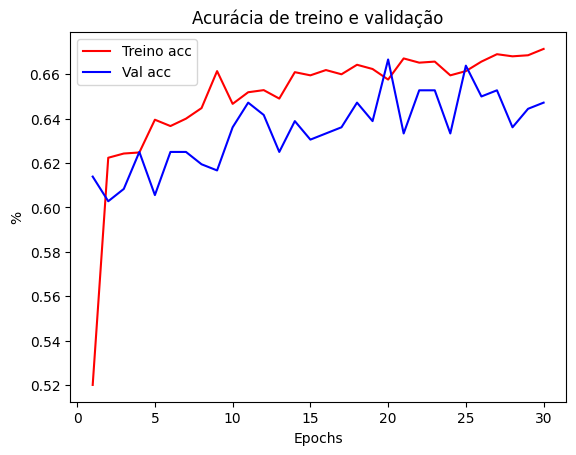

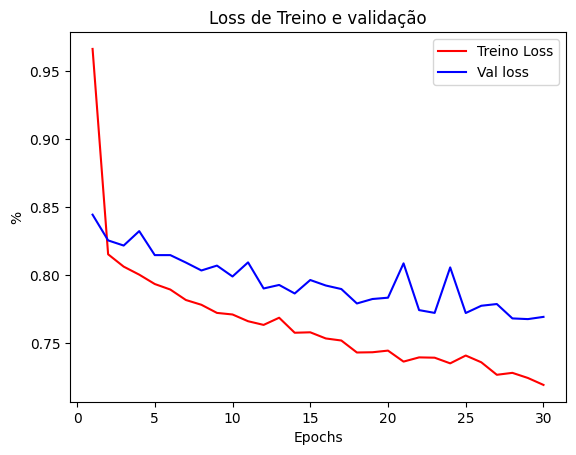

In [12]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)
plt.plot(epochs, accuracy,'r',label = 'Treino acc')
plt.plot(epochs, val_accuracy,'b',label = 'Val acc')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title("Acurácia de treino e validação")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'r',label='Treino Loss')
plt.plot(epochs,val_loss,'b',label = 'Val loss')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title("Loss de Treino e validação")
plt.legend()
plt.show()


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 9, 9, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,019 (74.30 KB)

 Trainable params: 6,339 (24.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,680 (49.54 KB)